## Library of Congress & Chronicling America

This notebook uses historic newspapers and select digitized newspaper pages provided by [Chronicling America](https://chroniclingamerica.loc.gov/about/) (ISSN 2475-2703).

This example is based on the [*Bourbon News*](https://chroniclingamerica.loc.gov/lccn/sn86069873/) began publication in 1881 in Millersburg, Kentucky under the ownership of Confederate veteran and former farmer Bruce Champ. By 1910, the paper had 3,000 subscribers, ranking it among the largest circulations in the Bluegrass region. The paper continued publishing until 1941.

[Chronicling America](https://chroniclingamerica.loc.gov/about/api/) provides an extensive application programming interface (API) which you can use to explore all of the data. The information is also [published as JSON](https://chroniclingamerica.loc.gov/lccn/sn86069873.json), including the OCR text files.

### Setting things up

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import pickle
import re
import os
from pathlib import Path
import requests
from collections import Counter
import matplotlib.pyplot as plt
from numpy import mean, ones
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Relationships between the volumes, issues and pages are describe in JSON. Each volume has several issues which contain several pages.

<img src="images/graph-loc.png">

### Let's retrieve the results!

The *Bourbon News* is accessible via a JSON file including all metadata. The attribute *issues* contains the URLs of all issues that, in turn, contain all *pages*.

In [ ]:
url = 'https://chroniclingamerica.loc.gov/search/pages/results/?state=&date1=1848&date2=1848&proxtext=french+revolution&x=24&y=18&dateFilterType=yearRange&rows=20&searchType=basic&format=json'

https://opentexts.world/search?advanced=true&title=french+revolution&creator=&yearfrom=1848&yearto=1848&publisher=&placeofpublication=
    
https://www.europeana.eu/es/collections/topic/18-newspapers?page=1&qf=proxy_dcterms_issued%3A%5B1848-01-01%20TO%201848-12-31%5D&view=grid&api=fulltext
    
    https://newspapers.eanadev.org/api/v2/search.json?query=french%20revolution&profile=hits&wskey=J6W44jvPV&&qf=proxy_dcterms_issued:%5B1848-01-01+TO+1848-12-31%5D

### Retrieving texts from in Chronicling America

In [10]:
count = 10
pagination = 100

queryString = 'french+revolution'
date = '1848'
page = 1

for page in range(9):
    url_pagination = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1='+ date +'&sort=relevance&rows=100&searchType=basic&sequence=0&state=&date2='+ date +'&proxtext='+queryString+'&y=18&x=24&dateFilterType=yearRange&page='+str(page+1)+'&format=json'
    print(url_pagination)
    r = requests.get(url_pagination)
    with open('ca-data'+str(page+1)+'.json', 'w') as outfile:
        json.dump(r.json(), outfile)


https://chroniclingamerica.loc.gov/search/pages/results/?date1=1848&sort=relevance&rows=100&searchType=basic&sequence=0&state=&date2=1848&proxtext=french+revolution&y=18&x=24&dateFilterType=yearRange&page=1&format=json
https://chroniclingamerica.loc.gov/search/pages/results/?date1=1848&sort=relevance&rows=100&searchType=basic&sequence=0&state=&date2=1848&proxtext=french+revolution&y=18&x=24&dateFilterType=yearRange&page=2&format=json
https://chroniclingamerica.loc.gov/search/pages/results/?date1=1848&sort=relevance&rows=100&searchType=basic&sequence=0&state=&date2=1848&proxtext=french+revolution&y=18&x=24&dateFilterType=yearRange&page=3&format=json
https://chroniclingamerica.loc.gov/search/pages/results/?date1=1848&sort=relevance&rows=100&searchType=basic&sequence=0&state=&date2=1848&proxtext=french+revolution&y=18&x=24&dateFilterType=yearRange&page=4&format=json
https://chroniclingamerica.loc.gov/search/pages/results/?date1=1848&sort=relevance&rows=100&searchType=basic&sequence=0&stat

In [11]:
import os, json
import pandas as pd

path_to_json = '.'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.startswith('ca-data') and pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']

['ca-data4.json', 'ca-data6.json', 'ca-data8.json', 'ca-data5.json', 'ca-data9.json', 'ca-data3.json', 'ca-data2.json', 'ca-data1.json', 'ca-data7.json']


### Now you can use pandas DataFrame.from_dict to read in the json (a python dictionary at this point) to a pandas dataframe:

In [26]:
# here I define my pandas Dataframe with the columns I want to get from the json
jsons_data = pd.DataFrame(columns=['county', 'city', 'edition', 'frequency', 'city', 'subject', 'date', 'publisher', 'language', 'lccn', 'title', 'place_of_publication', 'ocr_eng'])

In [42]:
   # JSON file 
#f = open('ca-data4.json') 
for js in json_files:
    print(js)
    f = open(js) 
  
    # Reading from file 
    data = json.load(f) 

    for i in data['items']:
        #print(i['sequence'])
        county = i['county']
        edition = i['edition']
        frequency = i['frequency']
        city = i['city']
        subject = i['subject']
        date = i['date']
        publisher = i['publisher']
        language = i['language']
        lccn = i['lccn']
        title = i['title']
        place_of_publication = i['place_of_publication']
        ocr_eng = i['ocr_eng']

        new_row = {'county':county, 'edition':edition, 'frequency':frequency,'city': city,'subject': subject,'date': date, 'publisher':publisher, 'language':language, 'lccn':lccn, 'title':title, 'place_of_publication':place_of_publication,'ocr_eng': ocr_eng}

        jsons_data = jsons_data.append(new_row, ignore_index=True)


    f.close()

print(jsons_data.head(5))

ca-data4.json
ca-data6.json
ca-data8.json
ca-data5.json
ca-data9.json
ca-data3.json
ca-data2.json
ca-data1.json
ca-data7.json
                     county                                  city edition  \
0  [None, None, Alexandria]  [Alexandria, Alexandria, Alexandria]    None   
1                 [Orleans]                         [New Orleans]    None   
2                 [Dubuque]                             [Dubuque]    None   
3                [New York]                            [New York]    None   
4                [New York]                            [New York]    None   

               frequency                                  city  \
0  Daily (except Sunday)  [Alexandria, Alexandria, Alexandria]   
1    Daily (except Sun.)                         [New Orleans]   
2                 Weekly                             [Dubuque]   
3                  Daily                            [New York]   
4                  Daily                            [New York]   

              

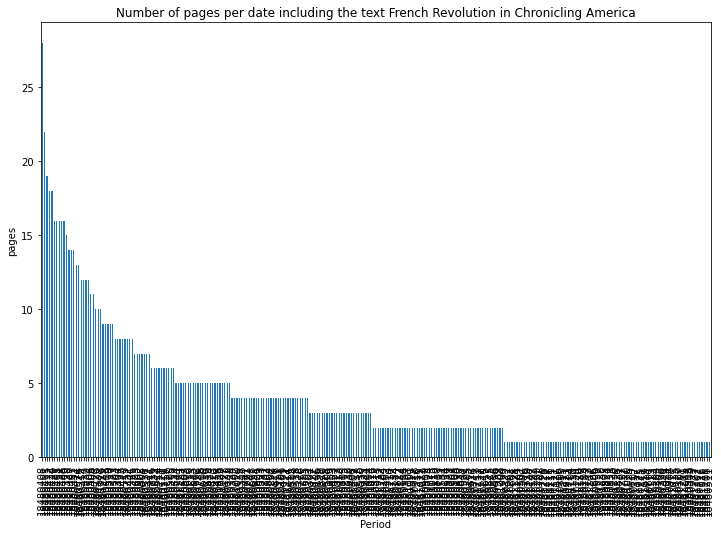

In [43]:
ax = jsons_data['date'].value_counts().plot(kind='bar',
                                    figsize=(12,8),
                                    title="Number of pages per date including the text French Revolution in Chronicling America")
ax.set_xlabel("Period")
ax.set_ylabel("pages")
plt.show()

In [50]:
jsons_data.groupby("date")["title"].count()

date
18480101    4
18480103    2
18480104    2
18480106    3
18480107    1
           ..
18481220    2
18481226    1
18481227    1
18481228    1
18481230    1
Name: title, Length: 275, dtype: int64

In [44]:
jsons_data.loc[jsons_data['date'] == '18480422']

,county,city,edition,frequency,city,subject,date,publisher,language,lccn,title,place_of_publication,ocr_eng
22,[None],[Washington],None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Weekly national intelligencer. [volume],Washington [D.C.],NATIONAL INTELLIGENCER.\nTEXAS AND THE UNITED ...
23,[None],[Washington],None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Weekly national intelligencer. [volume],Washington [D.C.],"j?c. n\nkiriT.lc'r-'.'L^, ?...! th.1 ?fa, lh....."
44,[None],[Washington],None,Daily (except Sunday and Monday),[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Thomas Ritchie & John P. Heiss,[English],sn82003410,The daily union. [volume],Washington [D.C.],"m""?"" """""" IITC mt | -A. A/ .2^ llf J*. - -A--....."
78,[Jefferson],[Louisville],None,Weekly,[Louisville],"[Antislavery movements--Kentucky--Newspapers.,...",18480422,P. Seymour,[English],sn82015050,The examiner. [volume],"Louisville, Ky.",THE EXAMINER.\nJ. ' VAIHiHsN. r.niM.\nr. CWBr....
122,[None],[Washington],None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Weekly national intelligencer. [volume],Washington [D.C.],NATIONAL INTELLIGENCER.\nTEXAS AND THE UNITED ...
123,[None],[Washington],None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Weekly national intelligencer. [volume],Washington [D.C.],"j?c. n\nkiriT.lc'r-'.'L^, ?...! th.1 ?fa, lh....."
144,[None],[Washington],None,Daily (except Sunday and Monday),[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Thomas Ritchie & John P. Heiss,[English],sn82003410,The daily union. [volume],Washington [D.C.],"m""?"" """""" IITC mt | -A. A/ .2^ llf J*. - -A--....."
178,[Jefferson],[Louisville],None,Weekly,[Louisville],"[Antislavery movements--Kentucky--Newspapers.,...",18480422,P. Seymour,[English],sn82015050,The examiner. [volume],"Louisville, Ky.",THE EXAMINER.\nJ. ' VAIHiHsN. r.niM.\nr. CWBr....
222,[None],[Washington],None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Weekly national intelligencer. [volume],Washington [D.C.],NATIONAL INTELLIGENCER.\nTEXAS AND THE UNITED ...
223,[None],[Washington],None,Weekly,[Washington],"[Washington (D.C.)--fast--(OCoLC)fst01204505, ...",18480422,Gales & Seaton,[English],sn83045784,Weekly national intelligencer. [volume],Washington [D.C.],"j?c. n\nkiriT.lc'r-'.'L^, ?...! th.1 ?fa, lh....."


In [45]:
jsons_data.date.unique()

array(['18480411', '18480325', '18480126', '18480504', '18480512',
       '18480516', '18480622', '18480522', '18480525', '18480417',
       '18480426', '18480404', '18480509', '18481209', '18480115',
       '18480304', '18480401', '18480408', '18480415', '18480422',
       '18480429', '18480506', '18480520', '18480527', '18480722',
       '18480916', '18481007', '18481014', '18481028', '18480708',
       '18480826', '18480302', '18480323', '18480409', '18480425',
       '18480428', '18480502', '18480526', '18480604', '18480609',
       '18480610', '18480613', '18480702', '18480714', '18480729',
       '18480925', '18481020', '18480911', '18481012', '18480407',
       '18480728', '18480330', '18480518', '18480308', '18480503',
       '18480510', '18480607', '18480823', '18480621', '18480816',
       '18480405', '18480128', '18480623', '18481214', '18480805',
       '18481125', '18480725', '18480414', '18480616', '18480412',
       '18480501', '18480624', '18480921', '18480603', '184811

In [46]:
jsons_data.language.astype(str).unique()

array(["['English']", "['English', 'Hawaiian']", "['English', 'French']"],
      dtype=object)

In [ ]:
url = 'https://chroniclingamerica.loc.gov/lccn/sn86069873.json'

r = requests.get(url)

ca_dict = json.loads(r.text)

df = pd.DataFrame(ca_dict['issues'])
df.head()

### How many issues?

In [ ]:
df.count()

## Retrieving the OCR texts from Chronicling America

**Note:**  This step may take a while to process due to the number of issues. Uncomment the code in order to execute this step.

In [ ]:
for index, row in df.iterrows():
    print(index, row['url'])
    response = requests.get(row['url'])
    text = ''
    if response:
        item = json.loads(response.text)
        text = ''
        for p in item['pages']:
            print(p)
            res_page = requests.get(p['url']) 
            json_page = json.loads(res_page.text)
            print(json_page['text'])
            text = text + requests.get(json_page['text']).text.replace('\n','')
            
#        response = requests.get(json_page['text'])
#        filename = Path('editions-ca/{}'.format(row['url'].replace('https://chroniclingamerica.loc.gov/lccn/sn86069873/','').replace('/', '_')))
#        filename.write_bytes(response.content) 
        outF = open('editions-ca/{}'.format(row['url'].replace('https://chroniclingamerica.loc.gov/lccn/sn86069873/','').replace('/', '_').replace('json', 'txt')), "w")
        outF.write(text) 
        outF.close()
df.head(10)   

## Now we load the text into pandas dataframe

In [ ]:
for index, row in df.iterrows():
    print(index, row['url'])
    
    filename = Path('editions-ca/{}'.format(row['url'].replace('https://chroniclingamerica.loc.gov/lccn/sn86069873/','').replace('/', '_').replace('json', 'txt')))
    
    text = ''
    
    if os.path.exists(filename):
        with open(filename, 'r') as myfile:
            text = myfile.read()
  
    df.loc[index, 'ocr_text'] = text

df.head()  

## Extracting the years from the dates

In [ ]:
for index,row in df.iterrows():
    
    try:
        df.loc[index, 'year'] = int(row['date_issued'][:4])
    except:
        df.loc[index, 'year'] = ''

In [ ]:
df.head(3)

### Creating a chart to visualize the results

This chart shows the number of resources by year.

In [ ]:
ax = df['year'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of resources per date")
ax.set_xlabel("Dates")
ax.set_ylabel("Resources")
plt.show()

Make a boolean mask

In [ ]:
#greater than the start date and smaller than the end date
mask = (df['year'] >= 1913) & (df['year'] <= 1920)

Select the sub-DataFrame

In [ ]:
decade = df.loc[mask]

We create an auxiliar class to store the terms and the codes

A minimal perfect hash is a birectional mapping between objects and consecutive integers

In [ ]:
class MPHash(object):
    # create from iterable 
    def __init__(self, terms):
        self.term = list(terms)
        self.code = {t:n for n, t in enumerate(self.term)}
    
    def __len__(self):
        return len(self.term)
    
    def get_code(self, term):
        return self.code.get(term)
    
    def get_term(self, code):
        return self.term[code]

## Extracting trend topics

This class recibes the texts to extract the trend topics by year.

In [ ]:
# A sample is a collection of texts and publication dates 
# For each text, the sample stores its year and word counts. 
class Sample(object):
    pattern = pattern = r"(?:\w+[-])*\w*[^\W\d_]\w*(?:[-'’`]\w+)*"
    # Create Sample from data stored in a DataFrame with at least columns 
    # TEXT, YEAR
    # n = maximal ngram size 
    def __init__(self, data, ngram_length):
        self.size = len(data)
        self.year = data.year.tolist()
        
        texts = tuple(data.ocr_text)
        vectorizer = CountVectorizer(token_pattern = Sample.pattern, 
                                     max_df=0.1,
                                     ngram_range=(1, ngram_length))
        matrix = vectorizer.fit_transform(texts).transpose() 
        # remove all hapax legomena to save space
        terms = vectorizer.get_feature_names()
        frequencies = matrix.sum(axis=1).A1
        selected = [m for m, f in enumerate(frequencies) if f > 1]
        hapax_rate = 1 - len(selected) / len(frequencies)
        print('Removing hapax legomena ({:.1f}%)'.format(100 * hapax_rate))
        self.matrix = matrix[selected, :]      
        self.term_codes = MPHash([terms[m] for m in selected])
        
        # store array with global term frequencies
        self.term_frequencies = self.matrix.sum(axis=1).A1
        # store doc frequencies
        self.doc_frequencies = self.matrix.getnnz(axis=1)
        # store most common capitalization of terms
        print('Obtaining most common capitalizations')
        vectorizer.lowercase = False
        matrix = vectorizer.fit_transform(texts).transpose()
        terms = vectorizer.get_feature_names()
        frequencies = matrix.sum(axis=1).A1    
        forms = dict()
        for t, f in zip(terms, frequencies):
            low = t.lower()
            if forms.get(low, (None, 0))[1] < f:
                forms[low] = (t, f)
        self.capitals = {k:v[0] for k, v in forms.items()}
        
        print('Computed stats for', len(self.term_codes), 'terms')
        
    # return the number of texts stored in this Sample
    def __len__(self):
        return self.size
    
    # return term frequency of the specified term
    def get_tf(self, term):
        code = self.term_codes.get_code(term.lower())
        
        return self.term_frequencies[code]
    
    # return document frequency of the specified term
    def get_df(self, term):
         code = self.term_codes.get_code(term.lower())
         
         return self.doc_frequencies[code]
     
    # return the most frequent capitalization form
    # (also for stopwords not in dictionary)
    def most_frequent_capitalization(self, term):
        return self.capitals.get(term.lower(), term)
    
    # return the average submission year of texts containing every term
    def average_year(self, period, tf_threshold=20, df_threshold=3):
        docs = [n for n, y in enumerate(self.year)\
                if period[0] <= y <= period[1]]
        tf_matrix = self.matrix[:, docs]
        tf_sum = tf_matrix.sum(axis=1).A1
        df_sum = tf_matrix.getnnz(axis=1)
        terms = [m for m, tf in enumerate(tf_sum)\
                 if tf >= tf_threshold and df_sum[m] >= df_threshold]
        tf_matrix = tf_matrix[terms, :]     
        rows, cols = tf_matrix.nonzero()
        df_matrix = csr_matrix((ones(len(rows)), (rows, cols)))
        year = [self.year[n] for n in docs]
        
        res = df_matrix @ year / df_matrix.getnnz(axis=1) # @ operator = matrix multiplication
        
        return {self.term_codes.get_term(terms[m]):res[m] for m in range(len(res))}

        
    # return the number of occurrences (doc frequency) for every term 
    def get_df_per_year(self, term):
        m = self.term_codes.get_code(term)
        row = self.matrix.getrow(m)
        _, docs = row.nonzero()
        c = Counter(map(self.year.__getitem__, docs))

        return c
          
    # return the number of occurrences (term frequency) for every term
    def tf_per_year(self, period=None):
        rows, cols = self.matrix.nonzero()
        res = {m:Counter() for m in rows}
        for m, n in zip(rows, cols):
            year = self.year[n]
            if period == None or period[0] <= year <= period[1]:
                res[m][year] += self.matrix[m, n]
            
        return res
    
    def plot_tf_series(self, term, period, relative=False):
        m = self.term_codes.get_code(term)
        if relative:
            norm = Counter(self.year)
        else:
            norm = Counter(set(self.year))
            
        if m:
            row = self.matrix.getrow(m)
            _, cols = row.nonzero()
            c = Counter()
            for n in cols:
                year = self.year[n]
                if period == None or period[0] <= year <= period[1]:
                    c[year] += row[0, n]
            
            X = sorted(c.keys())
            Y = [c[x] / norm[x] for x in X]
            plt.plot(X, Y, 'o-')
            plt.ylim(0, 1.2 * max(Y))
            plt.title(term)       
        else:
            raise ValueError('{} is not in store'.format(term))
             
    # return dictionary with a list of text-years per term 
    # period = pair of years (min _year, max_year) inclusive
    # keep_all = true if unlisted texts are not ignored
    def document_years(self, period=None, keep_all=True):
        rows, cols = self.matrix.nonzero()
        res = {m:list() for m in rows}
        for m, n in zip(rows, cols):
            if keep_all or self.listed[n]:
                year = self.year[n]
                print(year)
                if period == None or period[0] <= year <= period[1]:
                    res[m].append(year)
        
        return res
    
    # return dictionary with Counter of abstract-years per term
    def df_per_year(self, period=None, keep_all=True):
        doc_years = self.document_years(period, keep_all)
        
        return {m:Counter(v) for m, v in doc_years.items()}
    
    # create a plot with document frequency of terms
    def plot_df(self, terms, period, keep_all=True):
        dfs = self.df_per_year(period, keep_all)
        for term in terms:
            m = self.term_codes.get_code(term.lower())
            df = dfs[m] 
            X = range(*period)
            Y = [df.get(x, 0) for x in X]
            plt.clf()
            plt.plot(X, Y)
            plt.title(term)
            filename = 'plots/{}.png'.format(term)
            print('Saving', filename)
            plt.savefig(filename, dpi=200)
            
    # compute the average age in the specified period of documents containing 
    # each term with global term-frequency above tf_threshold
    # and annual document frequency above df_threshold (one year at least)
    # period = optional pair of years (min _year, max_year) inclusive
    def get_ages(self, period=None, 
                 tf_threshold=20, df_threshold=3, keep_all=True):
        res = dict()
        doc_years = self.document_years(period, keep_all)
        for m, values in doc_years.items():
            term = self.term_codes.get_term(m)
            if len(values) > 0:
                df = Counter(values).most_common(1)[0][1]
                tf = self.term_frequencies[m]
                #break;
                if df >= df_threshold and tf >= tf_threshold:       
                    res[term] = mean(values)
        return res
    
    # return abstract numbers containing any term in this set of terms
    def docs_with_term(self, terms, period=None):
        rows, cols = self.matrix.nonzero()
        res = set()
        for m, n in zip(rows, cols):
            term  = self.term_codes.get_term(m)
            if terms == None or term in terms:
                year = self.year[n]
                if period == None or period[0] <= year <= period[1]:
                     res.add(n)
                
        return res
            
       
    def search(self, term):
        m = self.term_codes.get_code(term)
        docs = self.matrix.getrow(m).nonzero()[1]
        
        return [(self.year[n], self.type[n], self.panel[n]) for n in docs]

### Using the Sample class to extract the trend topics

In [ ]:
# All data
#data = df

# dataframe 1912-1920
data = decade
decade

In [ ]:
data.ocr_text

In [ ]:
data = data[data.ocr_text.str.len() > 40]   

print('Processing', len(data), 'texts')

s = Sample(data, 2)

## Saving the pickle object

The [pickle](https://docs.python.org/3/library/pickle.html) module implements binary protocols for serializing and de-serializing a Python object structure.

In [ ]:
with open('sample-loc.pkl', 'wb') as f:
    pickle.dump(s, f)

In [ ]:
with open('sample-loc.pkl', 'rb') as f:
    s = pickle.load(f)
print('Loaded stats for', len(s), 'texts')

## Setting a period

In [ ]:
period = (1913, 1920)

In [ ]:
ages = s.get_ages(period)

In [ ]:
top = pd.DataFrame.from_dict(ages, orient='index').reset_index()
print(top)

In [ ]:
top.columns = ['TERM', 'AGE']
top = top.sort_values('AGE', ascending=False)#.head(250)   
top['DOC FREQ'] = top.TERM.apply(s.get_df)
top['TERM FREQ'] = top.TERM.apply(s.get_tf)

In [ ]:
# prepare to export
top['TERM'] = top.TERM.apply(s.most_frequent_capitalization)
print(top.set_index('TERM').head())

In [ ]:
ts = pd.datetime.now().strftime("%Y-%m-%d_%H.%M")    
filename = 'output/vocabulary_{}.xlsx'.format(ts)
with pd.ExcelWriter(filename) as writer:
    top.set_index('TERM').to_excel(writer, sheet_name='terms')

print('vocabulary saved to', filename)